# Implementation 4 - Multiple linear regression

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
import seaborn as sns

## Importing the data set

This data set is composed of records of money (in k€) invested in TV, radio and newspaper ads for specific products and the corresponding sales (in m$).

In [21]:
data = pd.read_csv("Advertising.csv", index_col=0)
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Data inspection

In [22]:
correlation = data.corr()
correlation

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


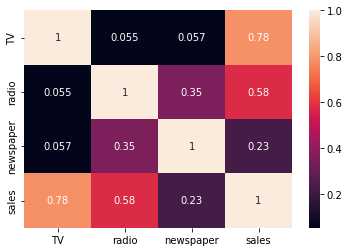

In [23]:
_ = sns.heatmap(correlation, annot=True)

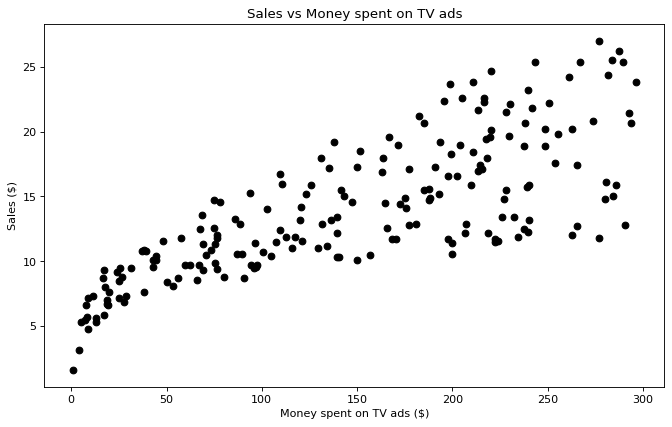

In [24]:
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(data['TV'], data['sales'], c='black')
plt.xlabel("Money spent on TV ads ($)")
plt.ylabel("Sales ($)")
plt.title("Sales vs Money spent on TV ads")
plt.show()

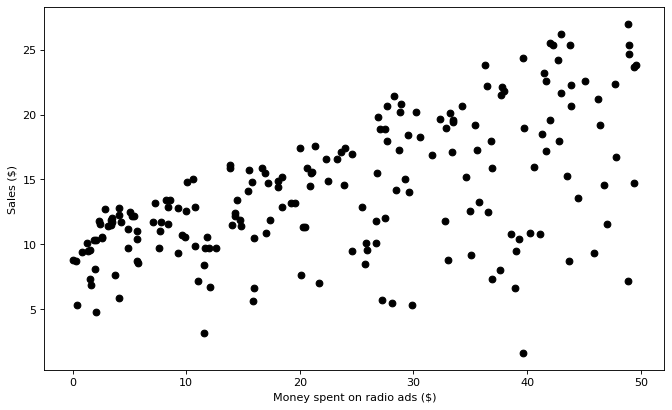

In [25]:
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(data['radio'], data['sales'], c='black')
plt.xlabel("Money spent on radio ads ($)")
plt.ylabel("Sales ($)")
plt.show()

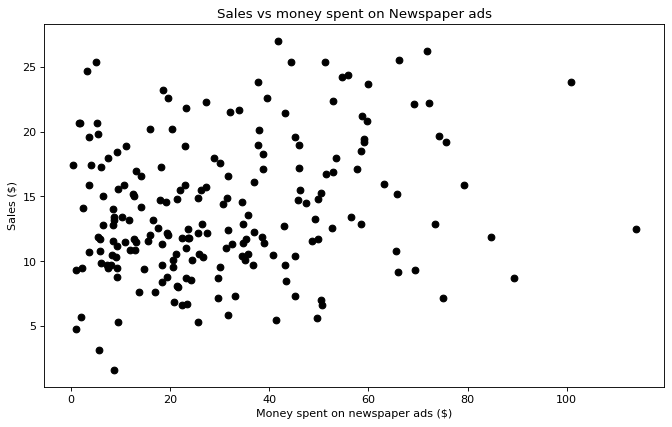

In [26]:
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(data['newspaper'], data['sales'], c='black')
plt.xlabel("Money spent on newspaper ads ($)")
plt.ylabel("Sales ($)")
plt.title("Sales vs money spent on Newspaper ads")
plt.show()

We notice from data inspection that 'sales' seems correlated with 'TV' and 'radio'.<br>
In this section, we will consider several features and the sales as the response.

## Data preparation

In [27]:
X = data.drop('sales', axis=1)
y = data['sales'].values.reshape(-1,1)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Single linear regression (reminder of ML_course03_implem)

In [29]:
X_train_single = X_train[['TV']]
X_val_single = X_val[['TV']]

### Model fit

In [30]:
from sklearn.linear_model import LinearRegression
reg_single = LinearRegression()
reg_single.fit(X_train_single, y_train)
print("The linear model is: Y = {:.2}  +  {:.2} * TV".format(reg_single.intercept_[0], reg_single.coef_[0][0]))

The linear model is: Y = 7.2  +  0.046 * TV


### Prediction Quality

In [31]:
y_single_pred = reg_single.predict(X_val_single)

In [32]:
from sklearn.metrics import r2_score

def evaluate_regression(y_pred, y_val):
    y_pred = y_pred.squeeze()
    y_val = y_val.squeeze()
    print("Mean square error (MSE): %.2f" % np.mean((y_pred - y_val) ** 2))
    print("Root mean square error (RMSE): %.2f" % np.sqrt(np.mean((y_pred - y_val) ** 2)))
    print("Mean absolute error (MAE): %.2f" % np.mean(abs(y_pred - y_val)))
    print("Coefficient of determination (R^2): %.2f" % r2_score(y_val, y_pred))

evaluate_regression(y_single_pred, y_val)

Mean square error (MSE): 8.73
Root mean square error (RMSE): 2.95
Mean absolute error (MAE): 2.30
Coefficient of determination (R^2): 0.69


## Multiple linear regression

### Model fit

In [33]:
reg_multiple = LinearRegression()
reg_multiple.fit(X_train, y_train)
print("The linear model is: Y = {:.2}  +  {:.2} * TV  +  {:.2} * radio  +  {:.2} * newspaper".format(reg_multiple.intercept_[0], reg_multiple.coef_[0][0], reg_multiple.coef_[0][1], reg_multiple.coef_[0][2]))

The linear model is: Y = 2.9  +  0.044 * TV  +  0.2 * radio  +  0.0012 * newspaper


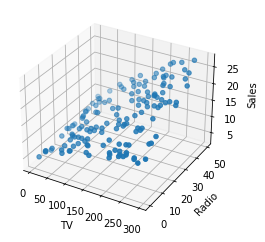

In [34]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_train['TV'], X_train['radio'], y_train.squeeze())
ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
plt.show()

### Prediction Quality

In [35]:
y_pred = reg_multiple.predict(X_val)

evaluate_regression(y_pred, y_val)

Mean square error (MSE): 4.01
Root mean square error (RMSE): 2.00
Mean absolute error (MAE): 1.30
Coefficient of determination (R^2): 0.86


## Polynomial regression

### Polynomial features based on TV feature only

#### What do the polynomial features look like?

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_single_poly = poly.fit_transform(X_train_single)

X_train_single_poly = pd.DataFrame(X_train_single_poly, columns=poly.get_feature_names_out())
X_train_single_poly.head()

,TV,TV^2
0,109.8,12056.04
1,229.5,52670.25
2,253.8,64414.44
3,184.9,34188.01
4,44.7,1998.09


#### The polynomial transformer can be integrated with a regressor in a Pipeline 

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

reg_single_poly = Pipeline([
    ('poly', poly),
    ('scaler', StandardScaler()),
    ('lin_regression', LinearRegression())
])
reg_single_poly.fit(X_train_single, y_train)
reg_single_poly.named_steps['lin_regression'].coef_

array([[ 6.17013309, -2.35047082]])

InvalidIndexError: (slice(None, None, None), None)

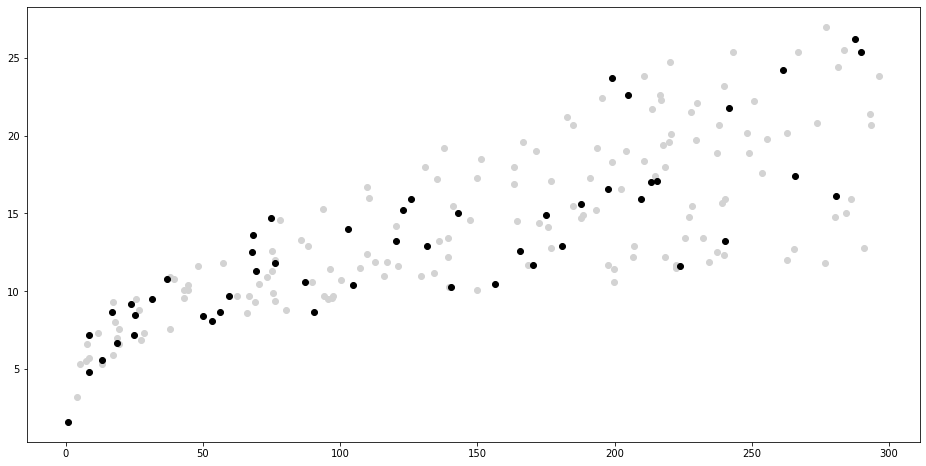

In [38]:
X_plot = pd.DataFrame({'TV': np.arange(min(data['TV']),max(data['TV']),1)})
y_single_plot = reg_single.predict(X_plot)
y_poly_plot = reg_single_poly.predict(X_plot)

plt.figure(figsize=(16, 8))
plt.scatter(X_train['TV'], y_train, c='lightgray')
plt.scatter(X_val['TV'], y_val, c='black')
plt.plot(X_plot, y_single_plot, c='lightblue', linewidth=2, label='single linear')
plt.plot(X_plot, y_poly_plot, c='blue', linewidth=2, label='polynomial')

plt.xlabel("Money spent on TV ads ($)")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()

### Model performance: Polynomial

In [39]:
y_pred = reg_single_poly.predict(X_val_single)
evaluate_regression(y_pred, y_val)

Mean square error (MSE): 9.04
Root mean square error (RMSE): 3.01
Mean absolute error (MAE): 2.34
Coefficient of determination (R^2): 0.68


### Polynomial Multiple linear regression (with interaction)

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly_multi = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
X_train_poly = poly_multi.fit_transform(X_train)

pd.DataFrame(X_train_poly, columns=poly_multi.get_feature_names_out()).head()

,1,TV,radio,newspaper,TV^2,TV radio,TV newspaper,radio^2,radio newspaper,newspaper^2
0,1.0,109.8,14.3,31.7,12056.04,1570.14,3480.66,204.49,453.31,1004.89
1,1.0,229.5,32.3,74.2,52670.25,7412.85,17028.90,1043.29,2396.66,5505.64
2,1.0,253.8,21.3,30.0,64414.44,5405.94,7614.00,453.69,639.00,900.00
3,1.0,184.9,21.0,22.0,34188.01,3882.90,4067.80,441.00,462.00,484.00
4,1.0,44.7,25.8,20.6,1998.09,1153.26,920.82,665.64,531.48,424.36


In [41]:
reg_multi = Pipeline([
    ('poly', poly_multi),
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])
reg_multi.fit(X_train, y_train)
reg_multi.named_steps['regression'].coef_

array([[ 0.00000000e+00,  4.27468491e+00,  3.56670496e-01,
         5.67459276e-04, -2.65819286e+00,  3.55319563e+00,
        -2.04832925e-01,  2.05151419e-01, -9.83370161e-03,
         1.78060575e-01]])

#### Accuracy

In [42]:
y_pred = reg_multi.predict(X_val)
evaluate_regression(y_pred, y_val)

Mean square error (MSE): 0.79
Root mean square error (RMSE): 0.89
Mean absolute error (MAE): 0.53
Coefficient of determination (R^2): 0.97


### Regularization 

We can try to increase the complexity of our model as much as we can to see if the validation error gets even lower.

In [43]:
overkill_poly = Pipeline([
    ('overkill_poly', PolynomialFeatures(degree=15, include_bias=True, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
overkill_poly.fit(X_train, y_train)
overkill_poly.named_steps['reg'].coef_

array([[ 1.45372345e-06,  1.67557582e+02, -1.23575401e+00,
         1.32571278e+02, -5.69640959e+02, -8.23798892e+01,
        -7.30567065e+02,  2.06135787e+02, -3.19716851e+02,
        -3.99411604e+02,  4.61860599e+02,  7.15986901e+02,
         1.55893515e+03, -1.95837557e+03,  1.59071371e+03,
         1.38652396e+03,  1.41625774e+03, -1.08305460e+03,
         1.30173214e+03,  4.26869137e+02,  7.06991005e+02,
        -9.10566114e+02, -1.00622048e+03,  2.39183518e+03,
        -2.92953640e+03, -1.49672993e+03,  1.80494948e+03,
         2.10315023e+03, -3.35380705e+03, -9.61132106e+02,
        -4.80305854e+03,  9.63362034e+02,  7.75213815e+02,
        -1.55021159e+03, -2.44936486e+02, -8.25392572e+02,
         3.65833515e+01, -7.49717693e+02, -7.19010405e+02,
         7.38096119e+02, -7.89445885e+02, -1.40159144e+03,
        -1.68204827e+03,  3.37299745e+03,  1.70897896e+03,
         2.05684289e+02,  1.35716178e+02, -1.94173284e+03,
         8.78666791e+02, -9.28820001e+02,  1.94263837e+0

In [44]:
y_pred = overkill_poly.predict(X_val)
evaluate_regression(y_val, y_pred)

Mean square error (MSE): 7433991885.70
Root mean square error (RMSE): 86220.60
Mean absolute error (MAE): 12567.51
Coefficient of determination (R^2): -0.02


Apparently not...  
Let's try a Ridge regression model instead

In [45]:
from sklearn.linear_model import Ridge
ridge = Pipeline([
    ('overkill_poly', PolynomialFeatures(degree=15, include_bias=True, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])
ridge.fit(X_train, y_train)
ridge.named_steps['ridge'].coef_

array([[ 0.00000000e+00,  3.48205460e+00,  4.80323945e-01,
         1.24816224e-01, -5.23330112e-01,  2.35097257e+00,
         3.85012816e-01, -9.37602136e-03,  3.06588406e-01,
        -1.09075811e-01, -9.35444681e-01,  4.17551716e-01,
        -6.21160562e-01,  8.82349220e-01,  4.86930646e-01,
         2.18572357e-01, -3.90689780e-02, -4.33620788e-02,
        -1.57086038e-01, -1.16783987e-02, -6.30433333e-01,
         6.95496776e-02, -5.11590177e-01, -5.15601279e-02,
        -1.41097995e-01, -1.49010120e-01,  3.09441475e-01,
         1.76632184e-01,  1.31830529e-01,  1.45097756e-01,
         4.21349982e-02, -9.77667195e-02, -2.44507618e-01,
        -1.23598168e-01,  7.41279159e-02, -2.93362914e-01,
         1.02579872e-01, -2.18719630e-01, -1.34450751e-01,
        -1.41151171e-01, -9.00579972e-02, -2.05905552e-01,
        -1.49861002e-01, -1.01964359e-01, -4.53672556e-02,
         9.75597180e-02,  6.76744718e-02,  4.27152150e-02,
         5.29660149e-02,  6.31858285e-02,  1.05140489e-0

In [46]:
y_pred = ridge.predict(X_val)
evaluate_regression(y_val, y_pred)

Mean square error (MSE): 24.24
Root mean square error (RMSE): 4.92
Mean absolute error (MAE): 1.48
Coefficient of determination (R^2): 0.46
